In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [7]:
# -----------------------------
# 1. Constants and units
# -----------------------------
e_charge = 1.602176634e-19  # Coulomb
proton_mass = 1.67262192369e-27  # kg

# For a demo, we can pick an AMS-like B ~ 0.15 T (order of magnitude)
B0 = np.array([0.0, 0.0, 0.15])  # Tesla, uniform field along +z

In [8]:
# -----------------------------
# 2. Lorentz force ODE system
# -----------------------------
def lorentz_rhs(t, y, q, m, B_vec):
    """
    Right-hand side for d/dt [x, y, z, vx, vy, vz].

    y = [x, y, z, vx, vy, vz]
    """
    x, y_pos, z, vx, vy, vz = y

    v = np.array([vx, vy, vz])
    B = B_vec

    # Lorentz force: F = q * v x B
    F = q * np.cross(v, B)

    # Acceleration
    a = F / m

    return [vx, vy, vz, a[0], a[1], a[2]]

def simulate_trajectory(
    q,
    m,
    B_vec,
    r0,
    v0,
    t_max,
    n_steps=2000
):
    """
    Integrate the trajectory of a charged particle in a uniform B field.

    Parameters
    ----------
    q : float
        Particle charge [C].
    m : float
        Particle mass [kg].
    B_vec : array-like, shape (3,)
        Magnetic field vector [T].
    r0 : array-like, shape (3,)
        Initial position [m].
    v0 : array-like, shape (3,)
        Initial velocity [m/s].
    t_max : float
        Total simulation time [s].
    n_steps : int
        Number of time steps.

    Returns
    -------
    t : ndarray
        Time array, shape (N,).
    traj : ndarray
        Trajectory array, shape (N, 6): [x, y, z, vx, vy, vz].
    """
    
    y0 = np.concatenate((np.array(r0, dtype=float),
                         np.array(v0, dtype=float)))

    t_eval = np.linspace(0, t_max, n_steps)

    sol = solve_ivp(
        lorentz_rhs,
        t_span=(0, t_max),
        y0=y0,
        args=(q, m, np.array(B_vec, dtype=float)),
        t_eval=t_eval,
        rtol=1e-9,
        atol=1e-9
    )

    if not sol.success:
        raise RuntimeError("Integration failed: " + sol.message)

    return sol.t, sol.y.T  # shape (N, 6)

In [9]:
# -----------------------------
# 3. Simple demo: proton in uniform B
# -----------------------------
# Example: 1 GeV/c proton. For a rough non-relativistic demo we pick a speed.
# Better: choose v as a fraction of c, e.g. v = 0.8 c
c = 3.0e8  # m/s
v_mag = 0.6 * c  # just for demonstration

# Let's tilt the velocity: some perpendicular, some parallel to B
theta = np.deg2rad(60)  # angle between v and B (B along z)
v_perp = v_mag * np.sin(theta)
v_par = v_mag * np.cos(theta)

v0 = np.array([v_perp, 0.0, v_par])  # initial velocity
r0 = np.array([0.0, 0.0, 0.0])       # start at origin

# Proton (positive charge)
q_p = +e_charge
m_p = proton_mass

# Estimate gyroperiod: T = 2π m / (|q| B)
omega_c = np.abs(q_p) * np.linalg.norm(B0) / m_p
T_c = 2 * np.pi / omega_c
print("Cyclotron period (s):", T_c)

# Simulate for a few gyroperiods
n_periods = 3.0
t_max = n_periods * T_c

t, traj = simulate_trajectory(
    q=q_p,
    m=m_p,
    B_vec=B0,
    r0=r0,
    v0=v0,
    t_max=t_max,
    n_steps=2000
)

x = traj[:, 0]
y = traj[:, 1]
z = traj[:, 2]

Cyclotron period (s): 4.3729649912393144e-07


In [10]:
def fit_circle_least_squares(x, y):
    """
    Basic circle fit using algebraic least squares.
    Returns (xc, yc, R).
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Build system: (x^2 + y^2, x, y, 1)
    A = np.column_stack([2*x, 2*y, np.ones_like(x)])
    b = x**2 + y**2

    # Solve A * params = b in least squares sense
    params, *_ = np.linalg.lstsq(A, b, rcond=None)
    a, b_param, c = params

    xc = a
    yc = b_param
    R = np.sqrt(c + xc**2 + yc**2)

    return xc, yc, R


def estimate_momentum_from_track(x, y, q, B_mag):
    """
    Estimate transverse momentum from (x,y) track assuming uniform B along z.

    Parameters
    ----------
    x, y : array-like
        Track positions in meters.
    q : float
        Particle charge [C].
    B_mag : float
        Magnetic field magnitude [T].

    Returns
    -------
    p_perp : float
        Transverse momentum [kg m / s].
    rigidity : float
        Rigidity p/|q| in [V s / m] ~ [T m^2 / s].
        Later we'll convert to GV.
    R_fit : float
        Fitted circle radius [m].
    """
    xc, yc, R_fit = fit_circle_least_squares(x, y)

    # p_perp = |q| B R
    p_perp = np.abs(q) * B_mag * R_fit

    rigidity = p_perp / np.abs(q)

    return p_perp, rigidity, R_fit


# Example: estimate from your simulated track
B_mag = np.linalg.norm(B0)
p_perp_est, rigidity_est, R_est = estimate_momentum_from_track(x, y, q_p, B_mag)

print(f"Estimated R (radius) = {R_est:.3e} m")
print(f"Estimated p_perp = {p_perp_est:.3e} kg·m/s")
print(f"Estimated rigidity = {rigidity_est:.3e} (SI units)")


Estimated R (radius) = 1.085e+01 m
Estimated p_perp = 2.607e-19 kg·m/s
Estimated rigidity = 1.627e+00 (SI units)


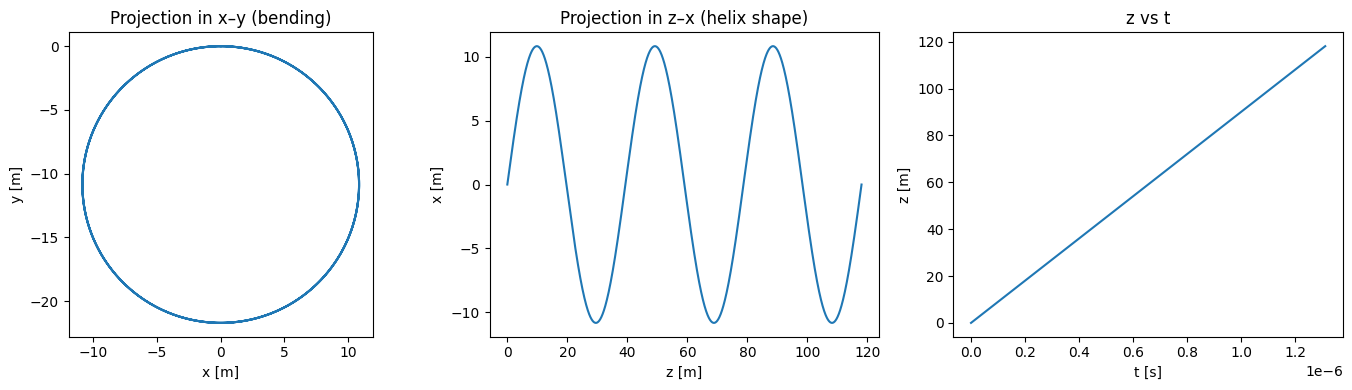

In [5]:
# -----------------------------
# 4. Plot projections
# -----------------------------
fig = plt.figure(figsize=(14, 4))

# (x, y) projection: circle
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x, y)
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")
ax1.set_aspect("equal", "box")
ax1.set_title("Projection in x–y (bending)")

# (x, z) projection: sinusoidal-ish
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(z, x)
ax2.set_xlabel("z [m]")
ax2.set_ylabel("x [m]")
ax2.set_title("Projection in z–x (helix shape)")

# z vs t: straight line if constant v_par
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(t, z)
ax3.set_xlabel("t [s]")
ax3.set_ylabel("z [m]")
ax3.set_title("z vs t")

plt.tight_layout()
plt.show()